In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm

In [2]:
tqdm.pandas()

In [3]:
k = 6
n = 28592
q = 1000

docs = pd.read_table('documents')
docs_series = docs['28592 6 1000']

In [4]:
def kshingles(doc, k=6):
    doc_len = len(doc)
    num_shingles = doc_len - k + 1
    return {doc[i:k+i] for i in range(num_shingles)}

In [5]:
kshingles_series = docs_series.progress_apply(kshingles)

100%|██████████████████████████████████████████████████████████████████████████| 28592/28592 [02:06<00:00, 225.95it/s]


In [ ]:
def build_tokenizer(shingle_series):
    all_shingles = set.union(*list(shingle_series))
    all_shingles_sorted = sorted(list(all_shingles))
    tokenizer = {all_shingles_sorted[i]:i for i in range(len(all_shingles_sorted))}
    return tokenizer

In [ ]:
tokenizer = build_tokenizer(kshingles_series)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def multi_hot(shingles, tokenizer, device):
    vec = torch.zeros(len(tokenizer), device=device, dtype=torch.float, requires_grad=False)
    for shingle in shingles:
        idx = tokenizer[shingle]
        vec[idx] = 1
    return vec

In [130]:
n_planes = 10  # number of hyperplanes
d = len(tokenizer) 

plane_norms = np.random.rand(n_planes, d) - .5
plane_norms = torch.from_numpy(plane_norms)
plane_norms = plane_norms.to(device)

In [131]:
def randomly_project(vector, plane_norms):
    with torch.no_grad():
        dot_prod = ((vector@plane_norms.T) > 0).bool()
        return dot_prod

In [ ]:
import math 

batch_size = 16
shingles_encoded = []
list_doc_shingles = list(kshingles_series)
for i in tqdm(range(math.ceil(len(list_doc_shingles)/batch_size))):
    batch = list_doc_shingles[batch_size*i: batch_size*(i+1)]
    batch = torch.stack([multi_hot(shingle_set, tokenizer, device) for shingle_set in batch])
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        encoding = randomly_project(batch, plane_norms.float())
        shingles_encoded.append(encoding)
        del batch

In [118]:
shingles_encoded = torch.concat(shingles_encoded)

In [121]:
shingles_encoded = shingles_encoded.int().cpu().numpy()

In [119]:
torch.save(shingles_encoded, 'shingles_encoded_10.pt')

In [9]:
import re
from collections import defaultdict
buckets = defaultdict(list) 
for i, encoding in enumerate(shingles_encoded):
    encoding_str = re.sub('[^0-9]','', str(encoding))
    buckets[encoding_str].append(i+1)

In [6]:
def jacard(idx1, idx2):
    intersect = len(kshingles_series[idx1 - 1].intersection(kshingles_series[idx2 - 1]))
    union = len(kshingles_series[idx1 - 1].union(kshingles_series[idx2 - 1]))
    return intersect/union

In [22]:
from itertools import combinations

pairs = []
for values in tqdm(buckets.values()):
    if len(values) >= 2:
        for comb in list(combinations(values, 2)):
            jc = jacard(comb[0], comb[1])
            if jc > 0.18:
                pairs += [(jc, [comb[0], comb[1]])]

100%|██████████████████████████████████████████████████████████████████████| 1014/1014 [19:20<00:00,  1.14s/it]


In [23]:
torch.save(pairs, 'most_similar_tuples.pt')

In [32]:
sorted_pairs = sorted(pairs,key=lambda x:(-x[0],x[1][0]))
n_sorted_pairs = sorted_pairs[:q]
torch.save(n_sorted_pairs, 'n_most_similar_tuples.pt')

In [7]:
n_sorted_pairs = torch.load('n_most_similar_tuples.pt')

Text(0.5, 0, 'Index')

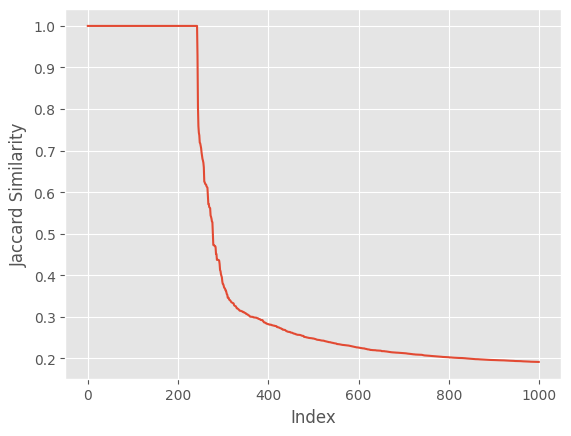

In [10]:
import matplotlib.pyplot as plt
scores = [pair[0] for pair in n_sorted_pairs]
plt.style.use('ggplot')
plt.plot(scores)
plt.ylabel('Jaccard Similarity')
plt.xlabel('Index')

In [35]:
answer_columns = [pair[1] for pair in n_sorted_pairs]
answer_df = pd.DataFrame(answer_columns)

In [38]:
answer_df.to_csv('lsh_ans', sep=' ', index=False, header=False)

In [11]:
tokenizer = torch.load('tokenizer.pt')